In [1]:


import yaml, torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch

import torchvision.transforms as transforms
# from torchvision.transforms import v2
from sklearn.manifold import TSNE

from tqdm import tqdm

In [2]:
import os, sys

project_dir = '/home/alcindo/projeto/swav-cows'
if project_dir not in sys.path:
    sys.path.insert(0, project_dir)
os.chdir(project_dir)


In [3]:
directory = '/home/alcindo/projeto/swav-cows/checkpoints/normalized_dataset/10proto/' 

with open(os.path.join(directory, "params.yaml"), 'r') as y_file:
    params = yaml.load(y_file, Loader=yaml.FullLoader)

In [4]:
params

{'data': {'crop_sizes': [[208, 576], [208, 576]],
  'max_scales': [1.0, 0.5],
  'min_scales': [1.0, 0.2],
  'n_hr_views': 2,
  'n_lr_views': 0,
  'root_dir': './normalized_dataset/'},
 'training': {'backbone_model': 'resnet18',
  'batch_size': 128,
  'checkpoints_file_path': './checkpoints/',
  'device': 'cuda',
  'learning_rate': 0.0001,
  'max_patience': 30,
  'min_epochs': 700,
  'n_features_swav': 128,
  'n_prototypes': 10,
  'sinkhorn_epsilon': 0.03,
  'weights_file_name': 'epoch_158.pth'}}

## Load dataset

In [5]:
from src.dataset import NumpyDataset
from torch.utils.data import DataLoader


dataset = NumpyDataset(os.path.join(params['data']['root_dir']))


dataloader = DataLoader(dataset, batch_size=params['training']['batch_size'], shuffle=True, drop_last=True)
    

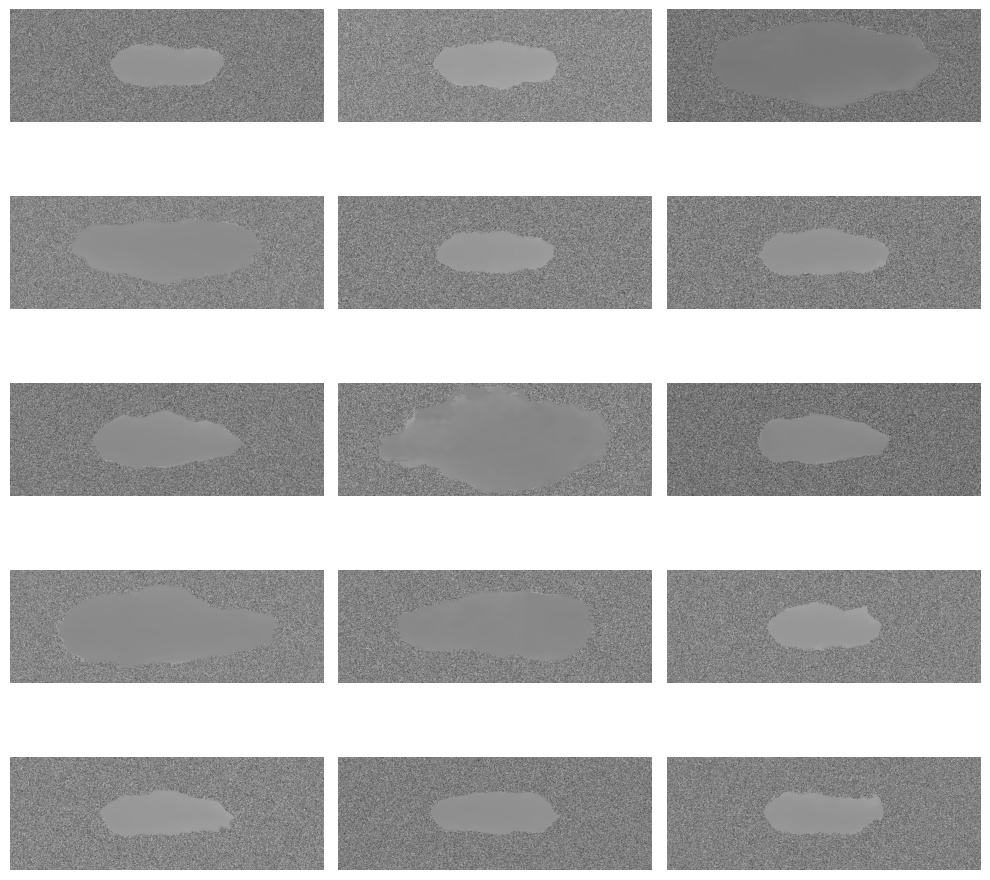

In [6]:
# plot 15 images from dataloader 5x3

for images in dataloader:
    images = images[:15]
    fig, axs = plt.subplots(5, 3, figsize=(10, 10))
    axs = axs.flatten()
    for i in range(len(images)):
        axs[i].imshow(images[i].permute(1, 2, 0).numpy(), cmap='gray')
        axs[i].axis('off')
    plt.tight_layout()
    plt.show()
    break

In [7]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device = "cpu"

from src.model import SwaV

model = SwaV(
    backbone_model  = params['training']['backbone_model'],
    input_size      = params['data']['crop_sizes'][0],
    n_hr_views      = params['data']['n_hr_views'],
    n_prototypes    = params['training']['n_prototypes'],
    n_features_swav = params['training']['n_features_swav'],
    batch_size      = params['training']['batch_size']
).to(device)

model.load_state_dict(torch.load(f"{directory}/minloss.pth", weights_only=True))




<All keys matched successfully>

In [8]:
model.eval()
similarities = []
features = []

with torch.no_grad():

    for img in tqdm(dataset):
        img = img.unsqueeze(0)
        f = model._subforward(img.to(device))[0]
        p = model.prototypes(f, step=2)
        features.append(f.to('cpu'))
        similarities.append(p.to('cpu'))


100%|██████████| 16556/16556 [04:50<00:00, 56.93it/s]


In [9]:

features = torch.vstack(features)
similarities = torch.vstack(similarities)
confidence, proto_assign = torch.max(torch.softmax(similarities, dim=-1), dim=-1)

swav_prototypes = model.prototypes.heads[0].weight.cpu().detach()


In [10]:
features

tensor([[ 0.1383,  0.0165, -0.1245,  ..., -0.0601,  0.1488, -0.1901],
        [ 0.1536,  0.0035, -0.1199,  ..., -0.0992,  0.1382, -0.1877],
        [ 0.0569, -0.0140, -0.0016,  ...,  0.0918,  0.0525,  0.0966],
        ...,
        [-0.0096,  0.0392,  0.1864,  ..., -0.1225, -0.0848, -0.0044],
        [ 0.1597,  0.1588, -0.0929,  ..., -0.0188,  0.0825, -0.0790],
        [-0.1308,  0.0752,  0.0378,  ..., -0.0565, -0.0250, -0.0790]])

In [11]:
from sklearn.manifold import TSNE

tsne = TSNE(random_state=0)
tsne_nd = torch.concat([features, swav_prototypes], axis=0)
tsne_2d = tsne.fit_transform(tsne_nd)

n_projs = len(features)
proj_2d, prot_2d = tsne_2d[:n_projs, :], tsne_2d[n_projs:, :]



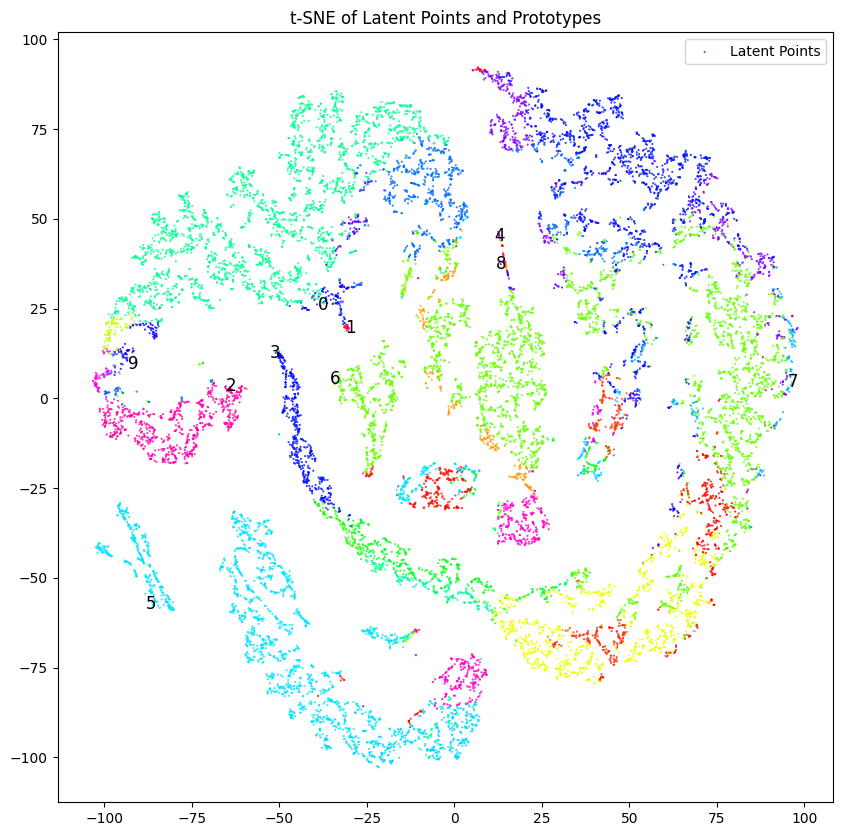

In [12]:
# Plot the TSNE results
cluster_labels = features.argmax(axis=1).cpu().numpy()
plt.figure(figsize=(10, 10))
plt.scatter(proj_2d[:, 0], proj_2d[:, 1], c= cluster_labels, cmap='hsv', label='Latent Points', s=0.2)
# plt.scatter(tsne_prot[:, 0], tsne_prot[:, 1], c='black', label='Prototypes', marker='.')
for i, (x, y) in enumerate(prot_2d):
    plt.text(x, y, i, color='black', fontsize=12, ha='center', va='center')

plt.legend()
plt.title("t-SNE of Latent Points and Prototypes")
plt.show()

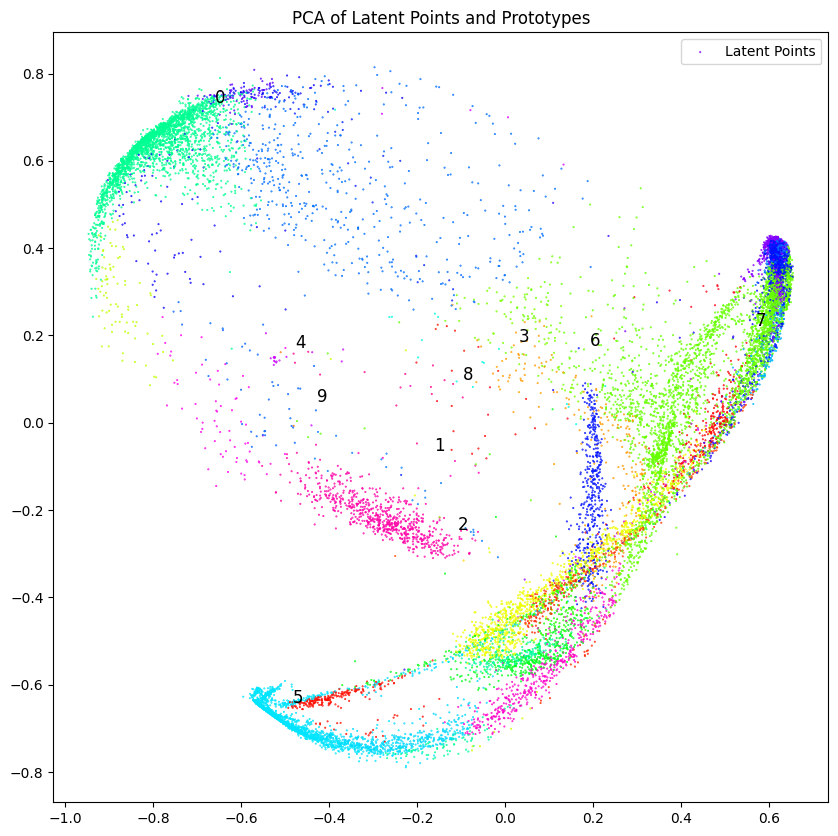

In [13]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_nd = torch.concat([features, swav_prototypes], axis=0)
pca_2d = pca.fit_transform(pca_nd)

n_projs = len(features)
proj_2d, prot_2d = pca_2d[:n_projs, :], pca_2d[n_projs:, :]

# Plot the PCA results
cluster_labels = features.argmax(axis=1).cpu().numpy()
plt.figure(figsize=(10, 10))
plt.scatter(proj_2d[:, 0], proj_2d[:, 1], c=cluster_labels, cmap='hsv', label='Latent Points', s=0.2)
for i, (x, y) in enumerate(prot_2d):
    plt.text(x, y, i, color='black', fontsize=12, ha='center', va='center')

plt.legend()
plt.title("PCA of Latent Points and Prototypes")
plt.show()

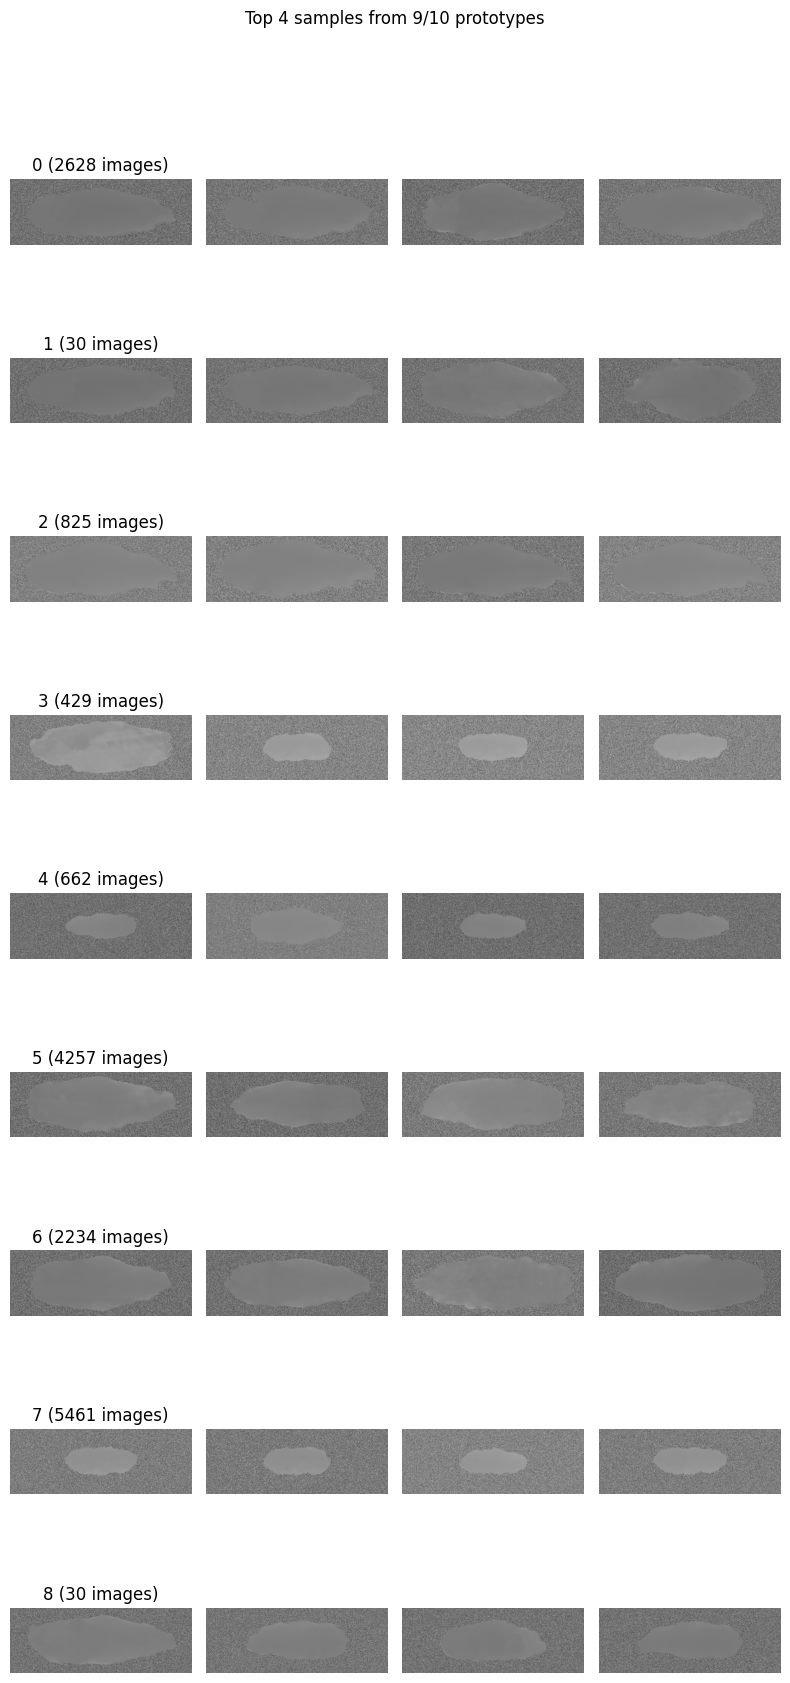

In [17]:
n_plots = 4
cluster_assign = proto_assign.numpy()
cluster_conf = confidence
n_proto = params['training']['n_prototypes']

unique_prototypes = proto_assign.unique().type(torch.uint16).tolist()
n_rows = max(2, len(unique_prototypes))

fig, ax = plt.subplots(n_rows, n_plots, figsize=(2*n_plots, 2*n_rows), layout='tight')
fig.suptitle(f'Top {n_plots} samples from {n_rows}/{n_proto} prototypes', y=1)

for ax0_idx, prototype_plot in enumerate(unique_prototypes):

    ax0 = ax[ax0_idx]

    prototype_img_idxs = np.array([
        img_idx 
        for img_idx in range(len(cluster_assign)) 
        if cluster_assign[img_idx] == prototype_plot
    ])

    if cluster_conf is not None:
        prototype_img_conf = cluster_conf.numpy()[prototype_img_idxs]
        prototype_img_idxs = prototype_img_idxs[np.flip(np.argsort(prototype_img_conf))]
        img_idxs_plot = prototype_img_idxs[:n_plots]

    else:
            img_idxs_plot = np.random.choice(prototype_img_idxs,n_plots)

    total_images = len(prototype_img_idxs)
    
    ax0[0].set_title(f'{prototype_plot} ({total_images} images)')

    for ax1 in ax0:
        ax1.axis('off')

    for ax1_idx, img_idx in enumerate(img_idxs_plot):
        img = dataset[img_idx]
        # Remove a dimensão do canal se for 1
        if img.shape[0] == 1:
            img = img.squeeze(0)
        ax0[ax1_idx].imshow(img, cmap='gray')

/home/alcindo/.pyenv/versions/swav-cows/lib/python3.10/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


IndexError: list index out of range

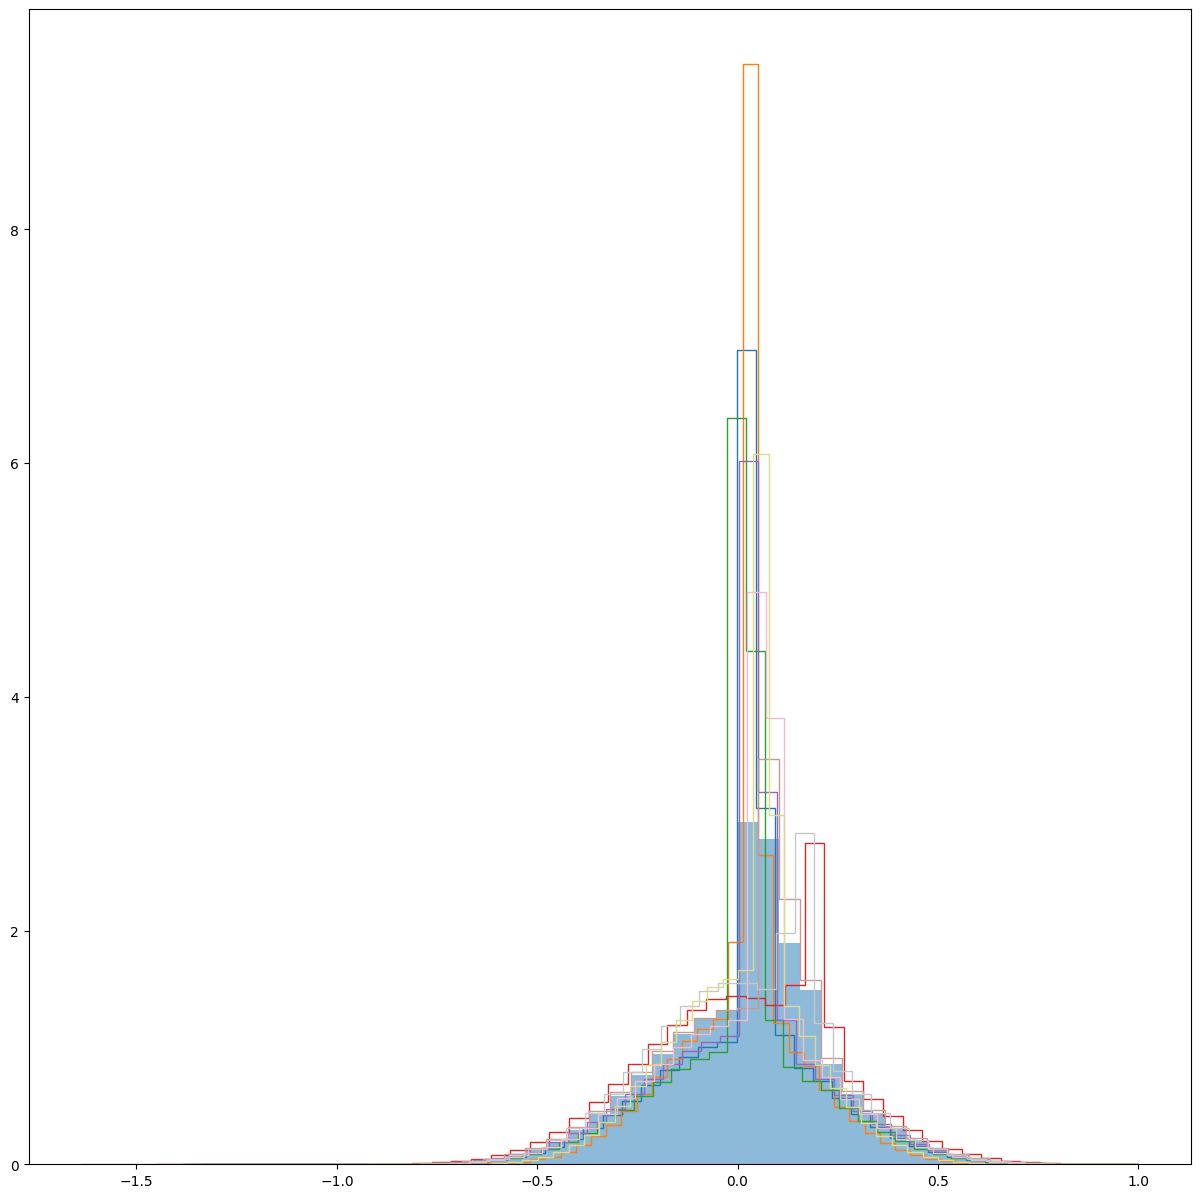

In [15]:
prototypes = swav_prototypes
assignments = proto_assign.numpy()

colors_c = [plt.colormaps['tab20'](c) for c in np.linspace(0, 1, num=len(prototypes))]
test_data_list = np.asarray(dataset)

#HISTOGRAM
n_bins = 50
fig, ax = plt.subplots(figsize=(15, 15))

plt.hist(test_data_list.ravel(),density=True,bins=n_bins,alpha = 0.5,label= 'self')

for num, cluster in enumerate(range(prototypes.shape[1])):

    cur_cluster = test_data_list[assignments==cluster].copy()
    cur_cluster_shape = cur_cluster.shape

    plt.hist(cur_cluster.ravel(),density=True,bins=n_bins,histtype='step',color=colors_c[num],label= f'{cluster}: {cur_cluster_shape[0]}')

plt.legend()
